### Check temperature sensor readings
Data we use are 
1. same as a01_OL_stroke.ipynb, taken on Thursday night (3/4/20)
2. data from each morning.

It was noted that 
Cell temperatures (4 of them) seem to be ~2C higher than mirror T (12 of them). Is that what we would expect?

See
https://jira.lsstcorp.org/secure/Tests.jspa#/testPlayer/testExecution/LVV-E1011

In [1]:
from openpyxl import load_workbook

from astropy.time import Time
from datetime import timedelta, datetime
from lsst_efd_client import EfdClient

import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
start = Time('2020-03-05T22:27:00') #this is UTC
end = Time('2020-03-05T22:38:00') 

client = EfdClient('summit_efd')
csc_index = 1

In [3]:
mat = scipy.io.loadmat('mat/0305/CellTelemetry_2020-03-05_203926_002.mat')
print(mat['data'].dtype.names)
mdata = mat['data']  # variable in mat file
mdtype = mdata.dtype  # dtypes of structures are "unsized objects"
ndata = {n: mdata[n][0, 0] for n in mdtype.names}
t = [datetime.strptime(ts[0][0], '%d-%b-%Y %H:%M:%S.%f') for ts in ndata['timestamp']]
t = np.array([ti+ timedelta(hours=4, minutes=3, seconds=-5) for ti in t]) #convert to utc, 4 hours ahead of Rochester
columns = [n for n, v in ndata.items()]
nonHP = [i for i in range(78) if i+1 not in ndata['hp'][0,:]]
nonHPa = [i for i in range(72) if i+1 not in ndata['hp'][0,:]] #a for axial actuator only

def insertHPColumns(a):
    [n1, n2] = a.shape
    b = np.zeros((n1, n2+6))
    ii = 0
    for i in range(n2+6):
        if i in nonHP:
            b[:,i] = a[:,ii]
            ii += 1
        else:
            b[:,i] = 0
    return b

ndata['f_hp'] = insertHPColumns(ndata['f_hp'])
ndata['f_error'] = insertHPColumns(ndata['f_error'])

('time_delta', 'comm_cntr', 'ilc_status', 'encoder', 'force', 'disp_sensors', 'temp_sensors', 'inclinometer', 'step_cmd', 'inc_cal', 'elevation_ts_i', 'elevation_ts_u', 'elevation_ang', 'el_status', 'disp_proc', 'disp_status', 'temp_proc', 'temp_status', 'hp', 'f_e', 'f_0', 'f_a', 'f_f', 'T_u', 'T_x', 'T_y', 'T_r', 'f_hp', 'f_cmd', 'f_error', 'f_delta', 'f_cmd_wrd', 'mtr_voltage', 'comm_voltage', 'mtr_current', 'comm_current', 'dig_input', 'dig_output', 'mtr_voltage_proc', 'comm_voltage_proc', 'mtr_current_proc', 'comm_current_proc', 'time', 'timestamp')


In [4]:
# cut out only the time period we are interested in
idx = (t>start) & (t<end)
data = {}
for n, v in ndata.items():
    if len(v.shape)>1:
        data[n] = v[idx,:]
    else:
        data[n] = v[idx]
t = t[idx]

In [5]:
#known bug, M2 sends utc everywhere.
df = await client.select_time_series('lsst.sal.MTM2.temperaturesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
df.head()

,exhaustTemperatures0,exhaustTemperatures1,exhaustTemperatures2,exhaustTemperatures3,intakeTemperatures0,intakeTemperatures1,intakeTemperatures2,intakeTemperatures3,private_host,private_kafkaStamp,...,temps65,temps66,temps67,temps68,temps69,temps7,temps70,temps71,temps8,temps9
2020-03-05 22:27:00.040000+00:00,24.516809,26.256799,-999,-999,23.62301,24.09939,-999,-999,1,1.583447e+09,...,-999,-999,-999,-999,-999,19.614496,-999,-999,19.733881,19.766107
2020-03-05 22:27:00.089000+00:00,24.516809,26.256799,-999,-999,23.62301,24.09939,-999,-999,1,1.583447e+09,...,-999,-999,-999,-999,-999,19.614496,-999,-999,19.733881,19.766107
2020-03-05 22:27:00.138000+00:00,24.516809,26.256799,-999,-999,23.62301,24.09939,-999,-999,1,1.583447e+09,...,-999,-999,-999,-999,-999,19.614496,-999,-999,19.733881,19.766107
2020-03-05 22:27:00.188000+00:00,24.516809,26.256799,-999,-999,23.62301,24.09939,-999,-999,1,1.583447e+09,...,-999,-999,-999,-999,-999,19.614496,-999,-999,19.733881,19.766107
2020-03-05 22:27:00.240000+00:00,24.516809,26.256799,-999,-999,23.62301,24.09939,-999,-999,1,1.583447e+09,...,-999,-999,-999,-999,-999,19.614496,-999,-999,19.733881,19.766107


#### 0 seems to match 0 (indexing)

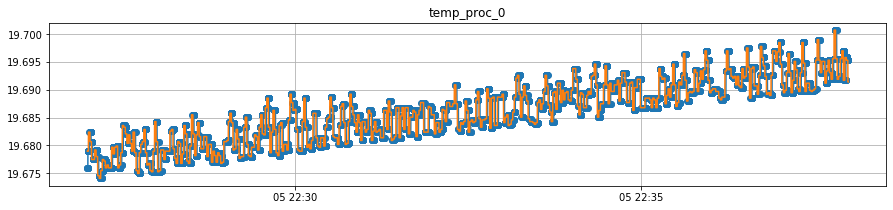

In [6]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(t, data['temp_proc'][:,0],'-o')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.temps0)
plt.title('temp_proc_0')
plt.grid()

### 12 is definitely not intake0

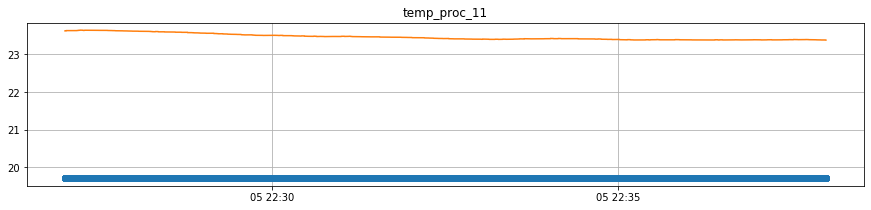

In [7]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(t, data['temp_proc'][:,12],'-o')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.intakeTemperatures0)
plt.title('temp_proc_11')
plt.grid()

In [8]:
data['temp_proc'][0,:]

array([19.67599869, 19.71090126, 19.70919991, 19.70830154, 23.62399864,
       24.51980019, 26.26050186, 24.0936985 , 19.73390007, 19.7628994 ,
       19.71069908, 19.71310043, 19.70949936, 19.61989975, 19.72119904,
       19.61470032])

### We could get some hints here
https://jira.lsstcorp.org/browse/DM-23523?filter=17301

In [9]:
print('%.2f %.2f %.2f %.2f'%(df.intakeTemperatures0[0], df.exhaustTemperatures0[0], 
                             df.exhaustTemperatures1[0], df.intakeTemperatures1[0]))
#print('%.2f %.2f %.2f %.2f'%(np.array([data['temp_proc'][0,i] for i in range(4,8)])))
print(' '.join(['%.2f'%data['temp_proc'][0,i] for i in range(4,8)]))

23.62 24.52 26.26 24.10
23.62 24.52 26.26 24.09


### We find the ordering of data['temp_proc'] vs EFD using the below.
how do we go from EFD temp data to binary temp data? 
* order EFD data as [0-11, intake0, intake1, exhaust0, exhaust1]
* use index: [0,1,2,3, 12,15,14,13, 8,9,10,11, 4,5,6,7] to get it into binary ordering (see below)
* use index: [1, 2, 3, 12, 9, 8, 13, 14, 15, 11, 10, 0] to get it into LUT ordering (see a03_LUT_0.ipynb).

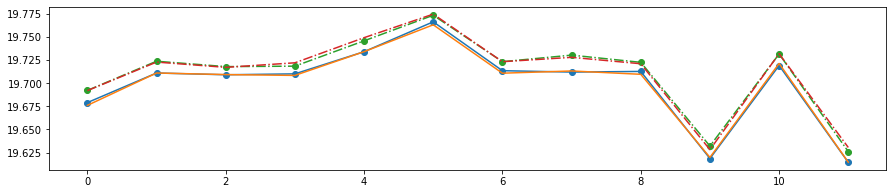

In [26]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(np.array([df['temps%d'%i][0] for i in [0,1,2,3,8,9,10,11,4,5,6,7]]),'-o')
plt.plot(np.array([data['temp_proc'][0,i] for i in [0,1,2,3,8,9,10,11,12,13,14,15]]))
plt.plot(np.array([df['temps%d'%i][10000] for i in [0,1,2,3,8,9,10,11,4,5,6,7]]),'-.o')
plt.plot(np.array([data['temp_proc'][10000,i] for i in [0,1,2,3,8,9,10,11,12,13,14,15]]),'-.');

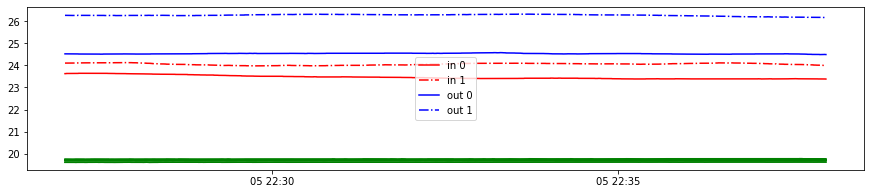

In [10]:
fig, ax = plt.subplots(figsize=(15,3))
bb = ['-','-.']
for i in range(2):
    plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['intakeTemperatures%d'%i], bb[i]+'r',label='in %d'%i)
for i in range(2):
    plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['exhaustTemperatures%d'%i], bb[i]+'b',label='out %d'%i)
for i in range(12):
    plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['temps%d'%i], 'g')
plt.legend(loc = 'center');

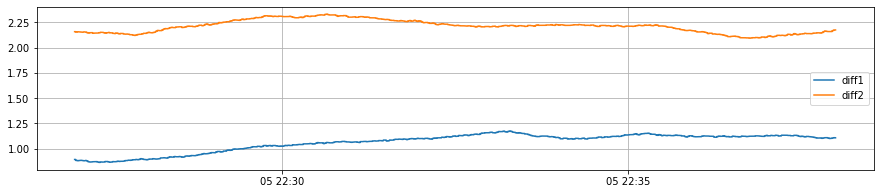

In [11]:
fig, ax = plt.subplots(figsize=(15,3))
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.exhaustTemperatures0 -df.intakeTemperatures0,label='diff1')
plt.plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.exhaustTemperatures1 -df.intakeTemperatures1,label='diff2')
plt.legend()
plt.grid()

### Mirror temp is pretty stable. Exhaust system seems to be taking out heat OK.
### Doug suggest we should be in better shape each morning when we started. Let's check the temp from each morning next.

3/3/20 no entry on first day, due to the NaN causing EFD to drop the topic. Angelo later fixed it.

In [13]:
start = Time('2020-03-03T14:07:01') #this is UTC
end = start+timedelta(minutes=5) 
#known bug, M2 sends utc everywhere.
df = await client.select_time_series('lsst.sal.MTM2.temperaturesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
df.head()

""


3/4/20

In [30]:
start = Time('2020-03-04T12:24:10') #this is UTC
end = start+timedelta(minutes=5) 
#known bug, M2 sends utc everywhere.
df = await client.select_time_series('lsst.sal.MTM2.temperaturesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
df.head()

,exhaustTemperatures0,exhaustTemperatures1,exhaustTemperatures2,exhaustTemperatures3,intakeTemperatures0,intakeTemperatures1,intakeTemperatures2,intakeTemperatures3,private_host,private_kafkaStamp,...,temps65,temps66,temps67,temps68,temps69,temps7,temps70,temps71,temps8,temps9
2020-03-04 12:24:10.029000+00:00,17.847681,17.944299,-999,-999,17.9927,17.855981,-999,-999,1,1.583325e+09,...,-999,-999,-999,-999,-999,18.078394,-999,-999,18.145502,18.135278
2020-03-04 12:24:10.080000+00:00,17.847681,17.944299,-999,-999,17.9927,17.855981,-999,-999,1,1.583325e+09,...,-999,-999,-999,-999,-999,18.078394,-999,-999,18.145502,18.135278
2020-03-04 12:24:10.129000+00:00,17.847681,17.944299,-999,-999,17.9927,17.855981,-999,-999,1,1.583325e+09,...,-999,-999,-999,-999,-999,18.078394,-999,-999,18.145502,18.135278
2020-03-04 12:24:10.180000+00:00,17.847681,17.944299,-999,-999,17.9927,17.855981,-999,-999,1,1.583325e+09,...,-999,-999,-999,-999,-999,18.078394,-999,-999,18.145502,18.135278
2020-03-04 12:24:10.230000+00:00,17.847681,17.944299,-999,-999,17.9927,17.855981,-999,-999,1,1.583325e+09,...,-999,-999,-999,-999,-999,18.078394,-999,-999,18.145502,18.135278


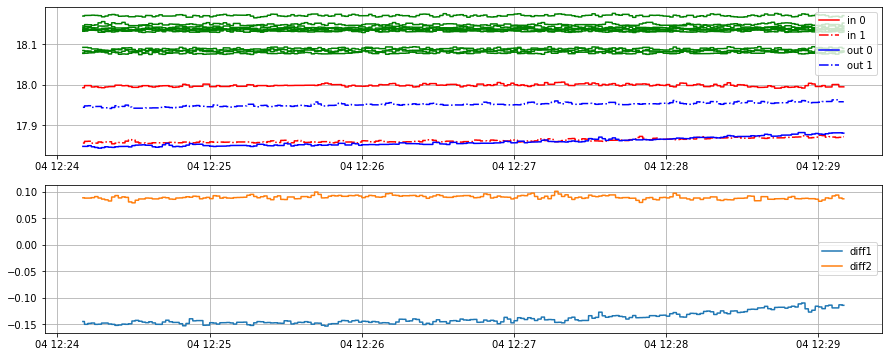

In [31]:
fig, ax = plt.subplots(2,1,figsize=(15,6))
bb = ['-','-.']
for i in range(2):
    ax[0].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['intakeTemperatures%d'%i], bb[i]+'r',label='in %d'%i)
for i in range(2):
    ax[0].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['exhaustTemperatures%d'%i], bb[i]+'b',label='out %d'%i)
for i in range(12):
    ax[0].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['temps%d'%i], 'g')
ax[0].grid()
ax[0].legend(loc = 'upper right');
ax[1].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.exhaustTemperatures0 -df.intakeTemperatures0,label='diff1')
ax[1].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.exhaustTemperatures1 -df.intakeTemperatures1,label='diff2')
ax[1].legend()
ax[1].grid()

3/5/20

In [28]:
start = Time('2020-03-05T13:46:08') #this is UTC
end = start+timedelta(minutes=5) 
#known bug, M2 sends utc everywhere.
df = await client.select_time_series('lsst.sal.MTM2.temperaturesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
df.head()

,exhaustTemperatures0,exhaustTemperatures1,exhaustTemperatures2,exhaustTemperatures3,intakeTemperatures0,intakeTemperatures1,intakeTemperatures2,intakeTemperatures3,private_host,private_kafkaStamp,...,temps65,temps66,temps67,temps68,temps69,temps7,temps70,temps71,temps8,temps9
2020-03-05 13:46:08.013000+00:00,19.031488,19.023889,-999,-999,19.024194,18.991907,-999,-999,1,1.583416e+09,...,-999,-999,-999,-999,-999,18.994104,-999,-999,19.066705,19.055383
2020-03-05 13:46:08.061000+00:00,19.031488,19.023889,-999,-999,19.024194,18.991907,-999,-999,1,1.583416e+09,...,-999,-999,-999,-999,-999,18.994104,-999,-999,19.066705,19.055383
2020-03-05 13:46:08.112000+00:00,19.031488,19.023889,-999,-999,19.024194,18.991907,-999,-999,1,1.583416e+09,...,-999,-999,-999,-999,-999,18.994104,-999,-999,19.066705,19.055383
2020-03-05 13:46:08.160000+00:00,19.031488,19.023889,-999,-999,19.024194,18.991907,-999,-999,1,1.583416e+09,...,-999,-999,-999,-999,-999,18.994104,-999,-999,19.066705,19.055383
2020-03-05 13:46:08.212000+00:00,19.031488,19.023889,-999,-999,19.024194,18.991907,-999,-999,1,1.583416e+09,...,-999,-999,-999,-999,-999,18.994104,-999,-999,19.066705,19.055383


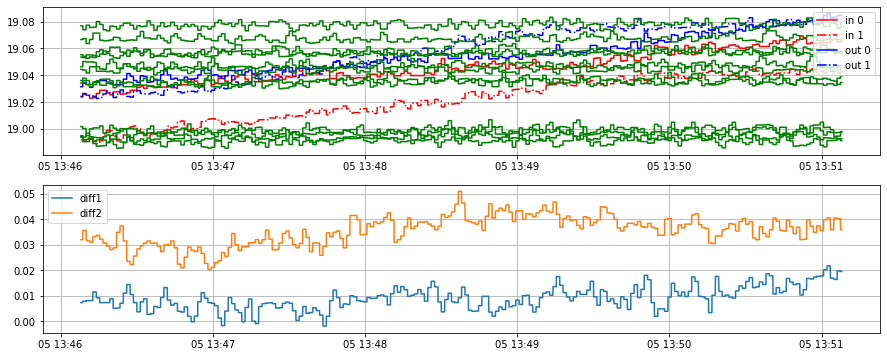

In [29]:
fig, ax = plt.subplots(2,1,figsize=(15,6))
bb = ['-','-.']
for i in range(2):
    ax[0].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['intakeTemperatures%d'%i], bb[i]+'r',label='in %d'%i)
for i in range(2):
    ax[0].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['exhaustTemperatures%d'%i], bb[i]+'b',label='out %d'%i)
for i in range(12):
    ax[0].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['temps%d'%i], 'g')
ax[0].grid()
ax[0].legend(loc = 'upper right');
ax[1].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.exhaustTemperatures0 -df.intakeTemperatures0,label='diff1')
ax[1].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.exhaustTemperatures1 -df.intakeTemperatures1,label='diff2')
ax[1].legend()
ax[1].grid()

3/6/20

In [34]:
start = Time('2020-03-06T12:51:12') #this is UTC
end = start+timedelta(minutes=5) 
#known bug, M2 sends utc everywhere.
df = await client.select_time_series('lsst.sal.MTM2.temperaturesMeasured', '*', 
                                     (start-timedelta(seconds=37)).tai, (end-timedelta(seconds=37)).tai, csc_index)
df.head()

,exhaustTemperatures0,exhaustTemperatures1,exhaustTemperatures2,exhaustTemperatures3,intakeTemperatures0,intakeTemperatures1,intakeTemperatures2,intakeTemperatures3,private_host,private_kafkaStamp,...,temps65,temps66,temps67,temps68,temps69,temps7,temps70,temps71,temps8,temps9
2020-03-06 12:51:12.030000+00:00,19.212885,19.19729,-999,-999,19.275385,19.27218,-999,-999,1,1.583499e+09,...,-999,-999,-999,-999,-999,19.419183,-999,-999,19.470911,19.462885
2020-03-06 12:51:12.081000+00:00,19.212885,19.19729,-999,-999,19.275385,19.27218,-999,-999,1,1.583499e+09,...,-999,-999,-999,-999,-999,19.419183,-999,-999,19.470911,19.462885
2020-03-06 12:51:12.130000+00:00,19.212885,19.19729,-999,-999,19.275385,19.27218,-999,-999,1,1.583499e+09,...,-999,-999,-999,-999,-999,19.419183,-999,-999,19.470911,19.462885
2020-03-06 12:51:12.181000+00:00,19.212885,19.19729,-999,-999,19.275385,19.27218,-999,-999,1,1.583499e+09,...,-999,-999,-999,-999,-999,19.419183,-999,-999,19.470911,19.462885
2020-03-06 12:51:12.232000+00:00,19.212885,19.19729,-999,-999,19.275385,19.27218,-999,-999,1,1.583499e+09,...,-999,-999,-999,-999,-999,19.419183,-999,-999,19.470911,19.462885


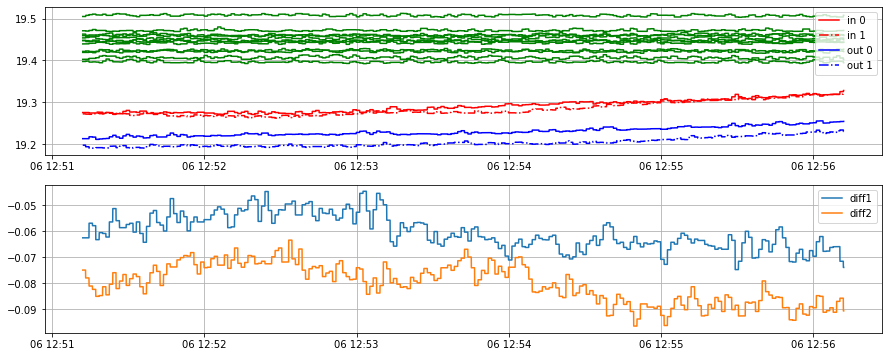

In [35]:
fig, ax = plt.subplots(2,1,figsize=(15,6))
bb = ['-','-.']
for i in range(2):
    ax[0].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['intakeTemperatures%d'%i], bb[i]+'r',label='in %d'%i)
for i in range(2):
    ax[0].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['exhaustTemperatures%d'%i], bb[i]+'b',label='out %d'%i)
for i in range(12):
    ax[0].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df['temps%d'%i], 'g')
ax[0].grid()
ax[0].legend(loc = 'upper right');
ax[1].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.exhaustTemperatures0 -df.intakeTemperatures0,label='diff1')
ax[1].plot(pd.to_datetime(df.private_sndStamp, unit='s'), df.exhaustTemperatures1 -df.intakeTemperatures1,label='diff2')
ax[1].legend()
ax[1].grid()

Chuck took this image circa end of 2019.
<img src="FLIR0138.jpeg">